Loading data...
Data merged. Shape: (5998, 15)
Feature Engineering complete. Final dataset shape: (5948, 46)
Training Samples: 5537 | Testing Samples: 411
Training Gradient Boosting Regressor...
------------------------------
Model Performance (Test Set > 2023-01-01):
RMSE: $47.29
R² Score: -0.8536
------------------------------


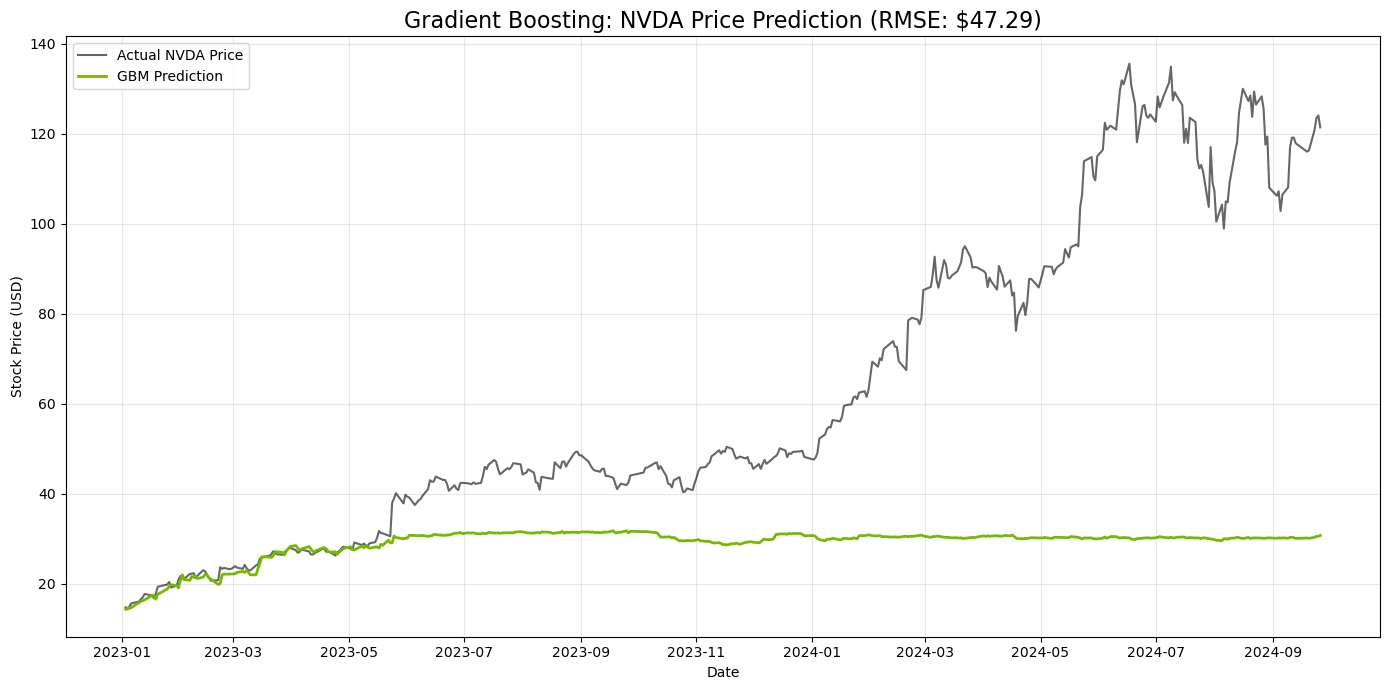


Top 10 Important Features:
            Feature  Importance
3        NVDA_Close    0.220670
38  CDNS_Close_MA50    0.107934
35  CDNS_Close_Lag1    0.090390
2          NVDA_Low    0.089333
30  SNPS_Close_Lag1    0.078834
28  ASML_Close_MA50    0.065792
1         NVDA_High    0.051014
36  CDNS_Close_Lag5    0.049982
20   TSM_Close_Lag1    0.038599
33  SNPS_Close_MA50    0.031410


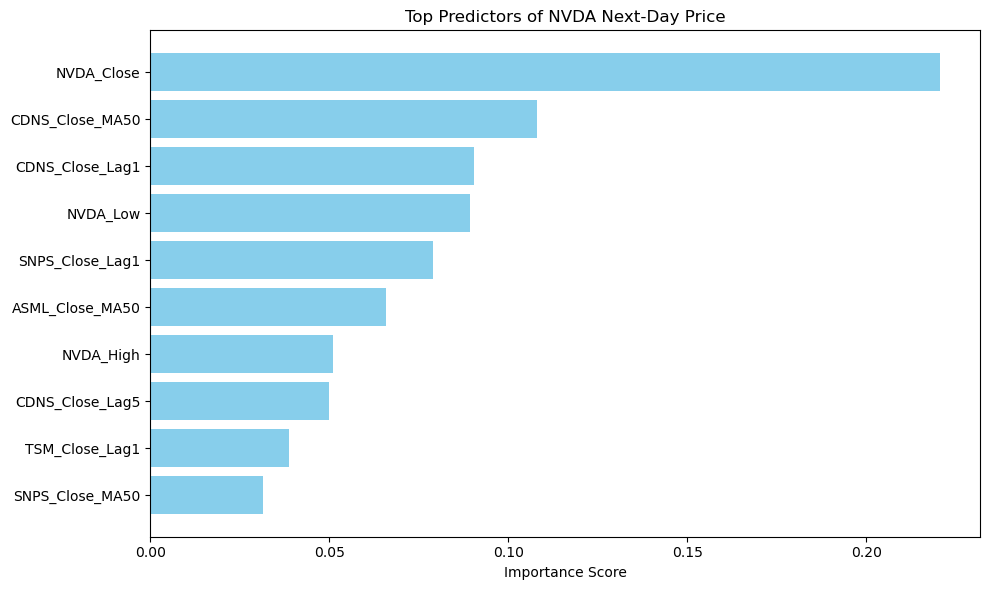

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Loading
def load_data(filepath, prefix):
    """Loads a CSV, converts Date to index, and prefixes column names."""
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    # Keep only 'Adj Close' and 'Volume' for suppliers to reduce noise
    df = df[['Adj Close', 'Volume']]
    df.columns = [f'{prefix}_Close', f'{prefix}_Volume']
    return df

# Load Main Target (NVDA), keep all columns for NVDA
print("Loading data...")
nvda = pd.read_csv('NVDA_daily_data.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda.set_index('Date', inplace=True)
nvda = nvda[['Open', 'High', 'Low', 'Adj Close', 'Volume']] # Keep core features
nvda.columns = ['NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume']

# Load Suppliers
tsm = load_data('TSM_daily_data.csv', 'TSM')
asml = load_data('ASML_daily_data.csv', 'ASML')
snps = load_data('SNPS_daily_data.csv', 'SNPS')
cdns = load_data('CDNS_daily_data.csv', 'CDNS')
samsung = load_data('005930.KS_daily_data.csv', 'Samsung') # Rename for clarity

# Merge all into one dataframe (Inner Join to ensure matching dates)
df = nvda.join([tsm, asml, snps, cdns, samsung], how='inner')
print(f"Data merged. Shape: {df.shape}")

# 2. Feature Engineering 
# Create features that represent the past to predict the future

# List of all stock prefixes
stocks = ['NVDA', 'TSM', 'ASML', 'SNPS', 'CDNS', 'Samsung']

for stock in stocks:
    col = f'{stock}_Close'
    
    # Lagged Features (Prices 1, 5, 10 days ago)
    df[f'{col}_Lag1'] = df[col].shift(1)
    df[f'{col}_Lag5'] = df[col].shift(5)
    
    # Moving Averages
    df[f'{col}_MA10'] = df[col].rolling(window=10).mean()
    df[f'{col}_MA50'] = df[col].rolling(window=50).mean()
    
    # Volatility (Risk - 20 day standard deviation)
    df[f'{col}_Vol20'] = df[col].rolling(window=20).std()

# 3. Target Creation & Cleanup
# We want to predict NVDA's Close price TOMORROW (t+1)
df['Target_NextDay_Price'] = df['NVDA_Close'].shift(-1)

# Drop NaNs created by lags (first 50 rows) and the target shift (last row)
df.dropna(inplace=True)

# Define X (Features) and y (Target)
X = df.drop(columns=['Target_NextDay_Price'])
y = df['Target_NextDay_Price']

print(f"Feature Engineering complete. Final dataset shape: {df.shape}")

# 4. Time-Series Split (Methodology)
# DO NOT shuffle. Train on the past, test on the "future".
# Use a cutoff date. Let's say train on everything up to 2023, test on 2023-2024.
split_date = '2023-01-01'

X_train = X.loc[:split_date]
X_test = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test = y.loc[split_date:]

print(f"Training Samples: {len(X_train)} | Testing Samples: {len(X_test)}")

# 5. Robust Scaling (Addressing Outliers)
# Professor's feedback: Use RobustScaler to handle shocks/tariffs better than StandardScaler
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Gradient Boosting Model Training
print("Training Gradient Boosting Regressor...")
gbm = GradientBoostingRegressor(
    n_estimators=200,     # Number of trees
    learning_rate=0.05,   # Step size (smaller is usually more accurate but slower)
    max_depth=4,          # Depth of trees (captures non-linearities)
    random_state=42
)

gbm.fit(X_train_scaled, y_train)

# 7. Evaluation
predictions = gbm.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("-" * 30)
print(f"Model Performance (Test Set > {split_date}):")
print(f"RMSE: ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print("-" * 30)

# 8. Visualization
# Plotting a subset of the test data for clarity (e.g., last 200 days)
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual NVDA Price', color='black', alpha=0.6)
plt.plot(y_test.index, predictions, label='GBM Prediction', color='#76b900', linewidth=2) # NVIDIA Green
plt.title(f'Gradient Boosting: NVDA Price Prediction (RMSE: ${rmse:.2f})', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9. Feature Importance (Root Cause Analysis)
# Which features mattered most
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbm.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

print("\nTop 10 Important Features:")
print(feature_importance)

# Visualization of Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top Predictors of NVDA Next-Day Price')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

--- Loading Data ---
Loaded NVDA: 1999-01-22 to 2024-09-27
Loaded TSM: 1997-10-09 to 2024-09-27
Loaded ASML: 1995-03-15 to 2024-09-27
Loaded SNPS: 1992-02-26 to 2024-09-27
Loaded CDNS: 1987-06-10 to 2024-09-27
Loaded Samsung: 2000-01-04 to 2024-09-27
Loaded MSFT: 1986-03-13 to 2021-09-29


C:\Users\22711\AppData\Local\Temp\ipykernel_28396\1187092484.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



Merged Data Date Range: 2000-01-04 to 2024-09-27
Total Rows: 6223

Split Date: 2023-01-01
Train Samples: 5737
Test Samples:  436

Training Gradient Boosting Model...
----------------------------------------
RMSE: $47.15
R²:   -0.8455
----------------------------------------


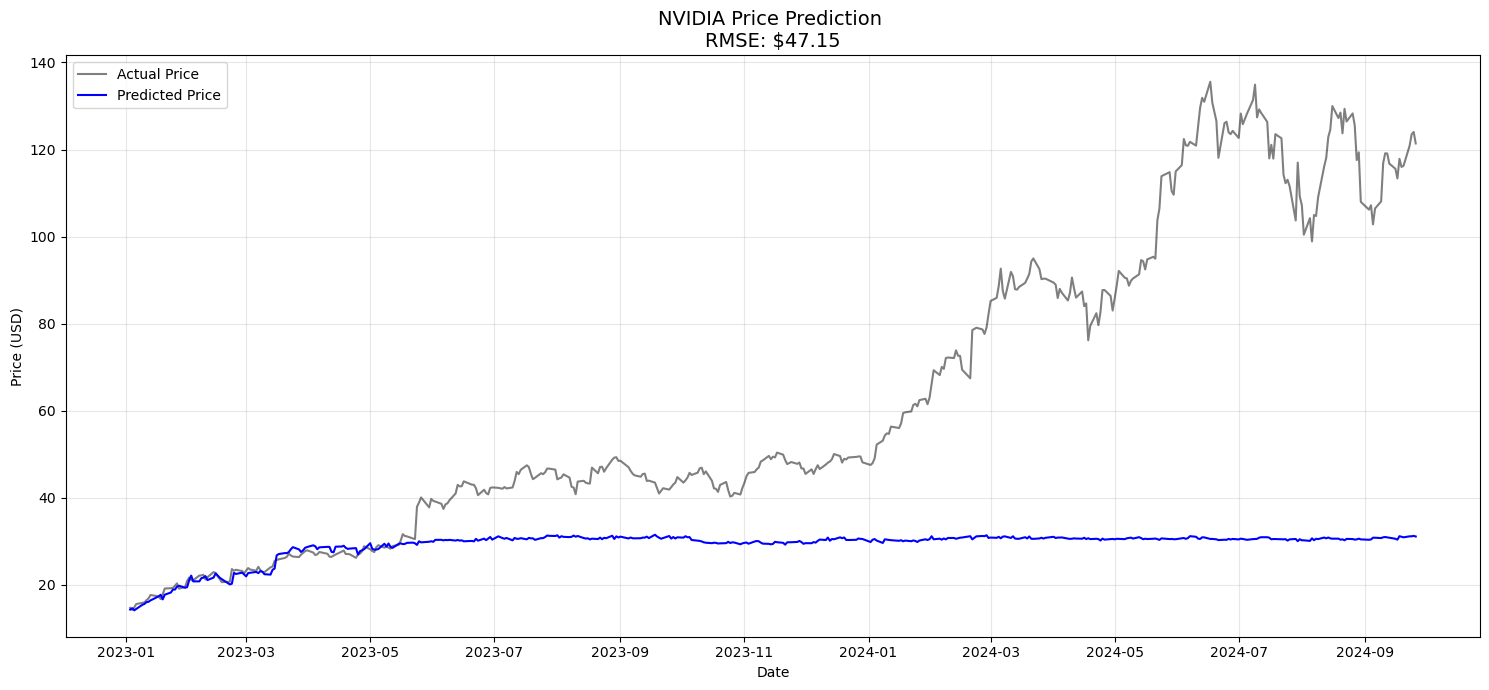


Top 15 Features:
       Feature  Importance
3   NVDA_Close    0.217071
41   CDNS_Lag1    0.168046
32   ASML_MA50    0.107894
35   SNPS_Lag1    0.100949
37   SNPS_MA10    0.087024
2     NVDA_Low    0.062071
44   CDNS_MA50    0.057931
1    NVDA_High    0.032274
55   MSFT_MA10    0.028271
20   NVDA_MA50    0.028192
42   CDNS_Lag5    0.025541
38   SNPS_MA50    0.018974
56   MSFT_MA50    0.017298
0    NVDA_Open    0.012511
15  MSFT_Close    0.010339


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Loading
def load_data(filepath, prefix):
    try:
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        
        # Handle cases where 'Adj Close' might be missing
        col_to_use = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
        
        # Select price and volume
        df = df[[col_to_use, 'Volume']].copy()
        df.columns = [f'{prefix}_Close', f'{prefix}_Volume']
        
        # Sort index just in case
        df.sort_index(inplace=True)
        
        # Debug: Print date range for each file
        print(f"Loaded {prefix}: {df.index.min().date()} to {df.index.max().date()}")
        return df
    except Exception as e:
        print(f"Error loading {prefix}: {e}")
        return pd.DataFrame()

print("--- Loading Data ---")
# 1. Target (NVIDIA) 
nvda = pd.read_csv('NVDA_daily_data.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda.set_index('Date', inplace=True)
nvda.sort_index(inplace=True)
nvda = nvda[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
nvda.columns = ['NVDA_Open', 'NVDA_High', 'NVDA_Low', 'NVDA_Close', 'NVDA_Volume']
print(f"Loaded NVDA: {nvda.index.min().date()} to {nvda.index.max().date()}")

# 2. Load Ecosystem
tsm = load_data('TSM_daily_data.csv', 'TSM')
asml = load_data('ASML_daily_data.csv', 'ASML')
snps = load_data('SNPS_daily_data.csv', 'SNPS')
cdns = load_data('CDNS_daily_data.csv', 'CDNS')
samsung = load_data('005930.KS_daily_data.csv', 'Samsung')
msft = load_data('Microsoft Stock Price (All Time).csv', 'MSFT')

# 3. Merging
# Use 'left' join to keep all NVDA trading days. 
# If MSFT or Samsung is missing a day (holiday/cutoff), it becomes NaN.
dfs_to_merge = [tsm, asml, snps, cdns, samsung, msft]
df = nvda.join(dfs_to_merge, how='left')

# Forward Fill: Propagate last valid observation forward 
df.fillna(method='ffill', inplace=True)

# Drop remaining NaNs 
df.dropna(inplace=True)

print(f"\nMerged Data Date Range: {df.index.min().date()} to {df.index.max().date()}")
print(f"Total Rows: {len(df)}")

# 4. Feature Engineering
tickers = ['NVDA', 'TSM', 'ASML', 'SNPS', 'CDNS', 'Samsung', 'MSFT']

for ticker in tickers:
    col_price = f'{ticker}_Close'
    
    # Safety check ensure column exists
    if col_price not in df.columns:
        continue

    # Lags
    df[f'{ticker}_Lag1'] = df[col_price].shift(1)
    df[f'{ticker}_Lag5'] = df[col_price].shift(5)
    
    # Moving Averages
    df[f'{ticker}_MA10'] = df[col_price].rolling(window=10).mean()
    df[f'{ticker}_MA50'] = df[col_price].rolling(window=50).mean()
    
    # Volatility
    df[f'{ticker}_Vol20'] = df[col_price].rolling(window=20).std()
    
    # Daily Return
    df[f'{ticker}_Ret'] = df[col_price].pct_change()

# Target: Predict Next Day
df['Target'] = df['NVDA_Close'].shift(-1)
df.dropna(inplace=True)

X = df.drop(columns=['Target'])
y = df['Target']

# 5. Time-Series Split
split_date = '2023-01-01'

X_train = X.loc[:split_date]
X_test = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test = y.loc[split_date:]

# CRITICAL CHECK
print(f"\nSplit Date: {split_date}")
print(f"Train Samples: {len(X_train)}")
print(f"Test Samples:  {len(X_test)}")

if len(X_test) == 0:
    raise ValueError("ERROR: X_test is empty! Check the 'Merged Data Date Range' above.")

# 6. Robust Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Gradient Boosting
print("\nTraining Gradient Boosting Model...")
gbm = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_samples_leaf=9,
    random_state=42
)

gbm.fit(X_train_scaled, y_train)

# 8. Evaluation
preds = gbm.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("-" * 40)
print(f"RMSE: ${rmse:.2f}")
print(f"R²:   {r2:.4f}")
print("-" * 40)

# 9. Visualization
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Actual Price', color='black', alpha=0.5)
plt.plot(y_test.index, preds, label='Predicted Price', color='blue', linewidth=1.5)
plt.title(f'NVIDIA Price Prediction \nRMSE: ${rmse:.2f}', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("price_predict_plot_1.png", dpi=900)
plt.show()

# 10. Feature Importance
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbm.feature_importances_
}).sort_values(by='Importance', ascending=False).head(15)

print("\nTop 15 Features:")
print(feat_imp)

--- Loading Ecosystem Data ---


C:\Users\22711\AppData\Local\Temp\ipykernel_28396\3515951633.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Training GBM on 5766 samples...
----------------------------------------
NEW STRATEGY RESULTS (Predicting Returns)
Test RMSE: $2.64
Test R²:   0.9942
----------------------------------------


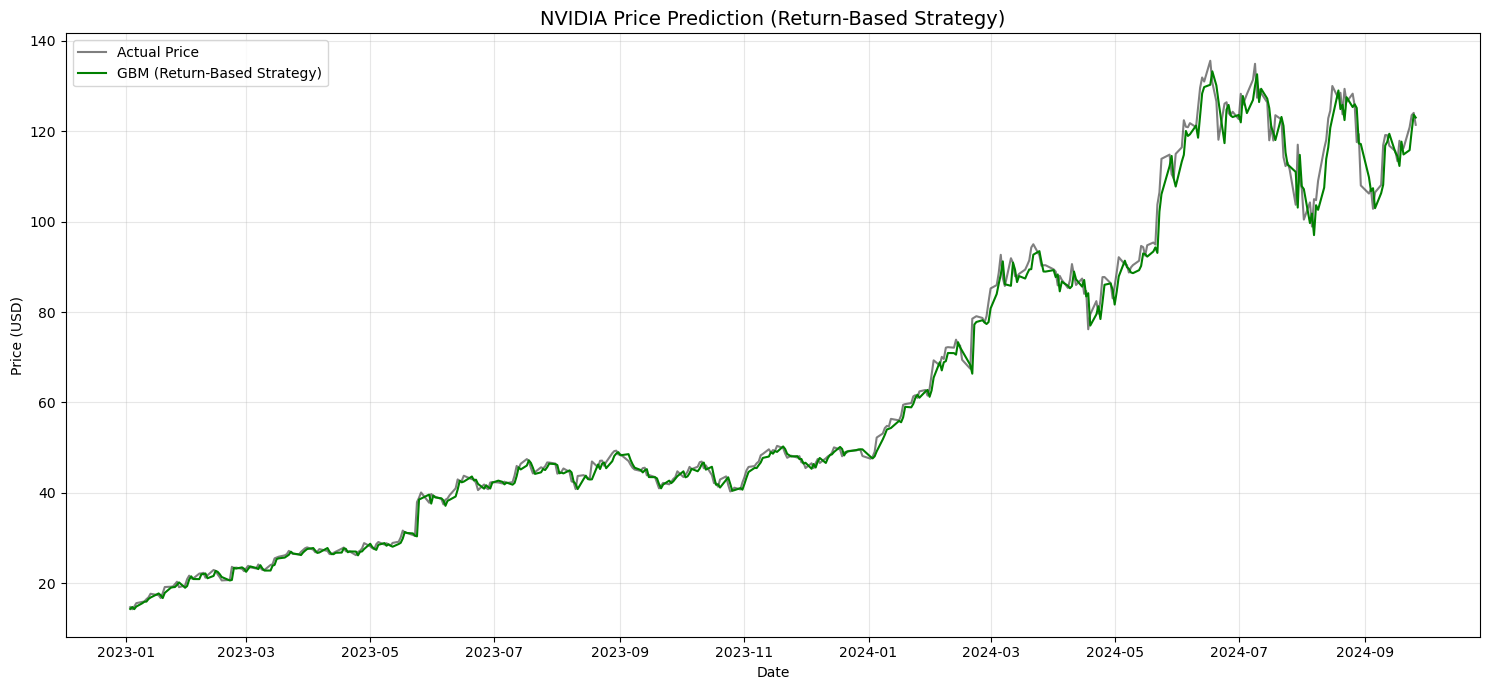


Top Predictors of Daily Return:
            Feature  Importance
16  NVDA_MA10_Ratio    0.072808
26         CDNS_Ret    0.055493
34  MSFT_MA10_Ratio    0.051627
29      Samsung_Ret    0.050096
9       CDNS_Volume    0.048413
32         MSFT_Ret    0.039349
3        TSM_Volume    0.038599
21       ASML_Vol20    0.037977
2         TSM_Close    0.036358
24       SNPS_Vol20    0.033694


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Loading
def load_data(filepath, prefix):
    try:
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        col_to_use = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
        df = df[[col_to_use, 'Volume']].copy()
        df.columns = [f'{prefix}_Close', f'{prefix}_Volume']
        return df
    except:
        return pd.DataFrame()

print("--- Loading Ecosystem Data ---")
nvda = pd.read_csv('NVDA_daily_data.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda.set_index('Date', inplace=True)
nvda = nvda[['Adj Close', 'Volume']]
nvda.columns = ['NVDA_Close', 'NVDA_Volume']

# Load Ecosystem
tsm = load_data('TSM_daily_data.csv', 'TSM')
asml = load_data('ASML_daily_data.csv', 'ASML')
snps = load_data('SNPS_daily_data.csv', 'SNPS')
cdns = load_data('CDNS_daily_data.csv', 'CDNS')
samsung = load_data('005930.KS_daily_data.csv', 'Samsung')
msft = load_data('Microsoft Stock Price (All Time).csv', 'MSFT')

# Merge & Fill
dfs = [tsm, asml, snps, cdns, samsung, msft]
df = nvda.join(dfs, how='left')
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# 2. Feature Engineering (Crucial Update)
tickers = ['NVDA', 'TSM', 'ASML', 'SNPS', 'CDNS', 'Samsung', 'MSFT']

for ticker in tickers:
    col = f'{ticker}_Close'
    
    # 1. DAILY RETURNS (Momentum) - Very important for this strategy
    df[f'{ticker}_Ret'] = df[col].pct_change()
    
    # 2. Volatility (Risk)
    df[f'{ticker}_Vol20'] = df[col].pct_change().rolling(window=20).std()
    
    # 3. Rolling Moving Averages (Trend)
    # Normalize these by dividing by current price so they work at any price level
    df[f'{ticker}_MA10_Ratio'] = df[col].rolling(window=10).mean() / df[col]

# 3. Define NEW Target (Returns)
# Predict the % change for tomorrow, not the dollar price.
df['Target_Return'] = df['NVDA_Close'].pct_change().shift(-1)

# Drop NaNs
df.dropna(inplace=True)

# Define X and y
X = df.drop(columns=['Target_Return'])
y = df['Target_Return']

# 4. Split Data
split_date = '2023-01-01'

X_train = X.loc[:split_date]
X_test = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test = y.loc[split_date:]

# Use "Today's Price" to calculate "Tomorrow's Price"
test_prices_today = X_test['NVDA_Close']

# 5. Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Train GBM on Returns
print(f"Training GBM on {len(X_train)} samples...")
gbm = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.03,  # Slower learning for noisy return data
    max_depth=4,
    random_state=42
)
gbm.fit(X_train_scaled, y_train)

# 7. Prediction & Reconstruction (The Magic Step)
# 1. Predict the Return (e.g., 0.02 for +2%)
pred_returns = gbm.predict(X_test_scaled)

# 2. Reconstruct the Price: Price_Tomorrow = Price_Today * (1 + Predicted_Return)
pred_prices = test_prices_today * (1 + pred_returns)

# 3. Get Actual Tomorrow Prices for comparison
actual_prices = test_prices_today * (1 + y_test)

# 8. Evaluation
rmse = np.sqrt(mean_squared_error(actual_prices, pred_prices))
r2 = r2_score(actual_prices, pred_prices)

print("-" * 40)
print(f"NEW STRATEGY RESULTS (Predicting Returns)")
print(f"Test RMSE: ${rmse:.2f}")
print(f"Test R²:   {r2:.4f}")
print("-" * 40)

# 9. Plotting 
plt.figure(figsize=(15, 7))
plt.plot(actual_prices.index, actual_prices, label='Actual Price', color='black', alpha=0.5)
plt.plot(pred_prices.index, pred_prices, label='GBM (Return-Based Strategy)', color='green', linewidth=1.5)
plt.title(f'NVIDIA Price Prediction (Return-Based Strategy)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 10. Check Feature Importance for Returns
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gbm.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

print("\nTop Predictors of Daily Return:")
print(feat_imp)

--- Loading Data ---


C:\Users\22711\AppData\Local\Temp\ipykernel_28396\4027054427.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Class Balance (Up vs Down):
Target_Class
1    0.517169
0    0.482831
Name: proportion, dtype: float64

Training Classifier...

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.44      0.91      0.59       190
           1       0.59      0.11      0.18       247

    accuracy                           0.45       437
   macro avg       0.51      0.51      0.38       437
weighted avg       0.52      0.45      0.36       437

ROC-AUC Score: 0.5258


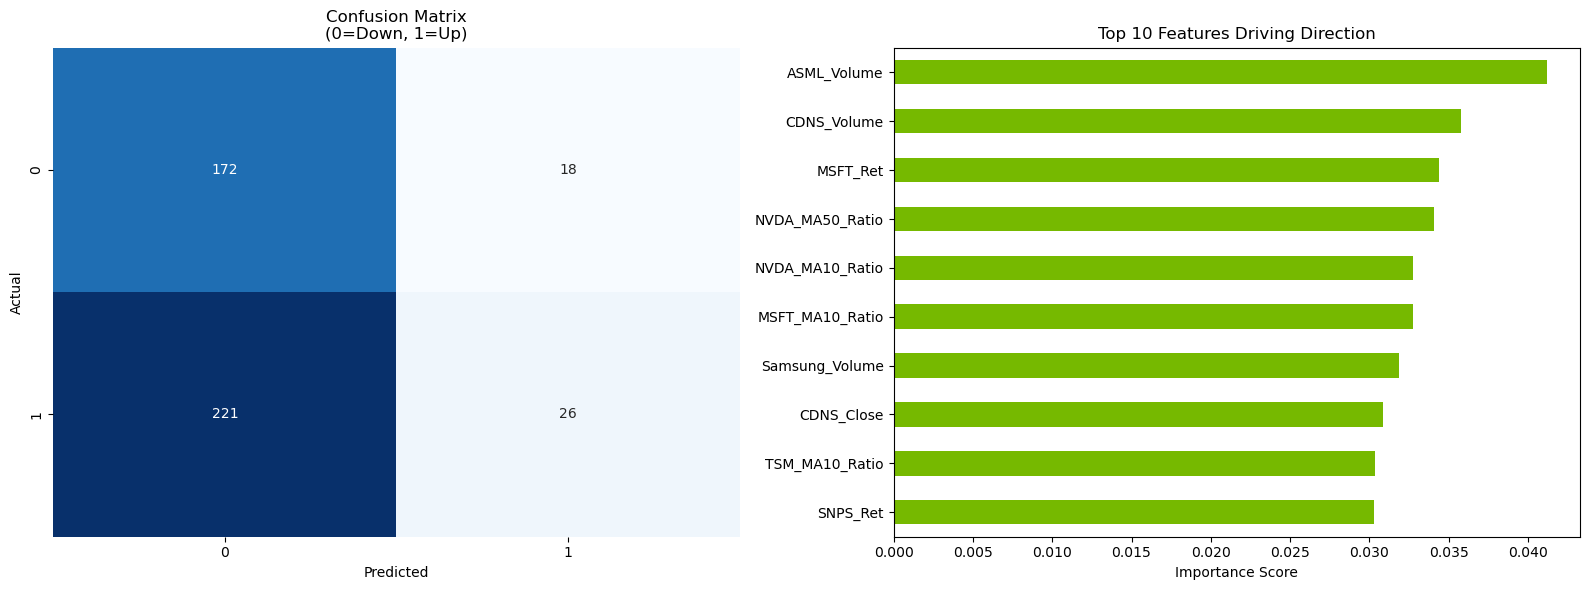

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 1. Data Loading
def load_data(filepath, prefix):
    try:
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        col_to_use = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
        df = df[[col_to_use, 'Volume']].copy()
        df.columns = [f'{prefix}_Close', f'{prefix}_Volume']
        return df
    except:
        return pd.DataFrame()

print("--- Loading Data ---")
nvda = pd.read_csv('NVDA_daily_data.csv')
nvda['Date'] = pd.to_datetime(nvda['Date'])
nvda.set_index('Date', inplace=True)
nvda = nvda[['Adj Close', 'Volume']]
nvda.columns = ['NVDA_Close', 'NVDA_Volume']

# Load Ecosystem
tsm = load_data('TSM_daily_data.csv', 'TSM')
asml = load_data('ASML_daily_data.csv', 'ASML')
snps = load_data('SNPS_daily_data.csv', 'SNPS')
cdns = load_data('CDNS_daily_data.csv', 'CDNS')
samsung = load_data('005930.KS_daily_data.csv', 'Samsung')
msft = load_data('Microsoft Stock Price (All Time).csv', 'MSFT')

# Merge & Fill
dfs = [tsm, asml, snps, cdns, samsung, msft]
df = nvda.join(dfs, how='left')
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# 2. Feature Engineering
tickers = ['NVDA', 'TSM', 'ASML', 'SNPS', 'CDNS', 'Samsung', 'MSFT']

for ticker in tickers:
    col = f'{ticker}_Close'
    
    # Momentum (Daily Return)
    df[f'{ticker}_Ret'] = df[col].pct_change()
    
    # Volatility (Risk)
    df[f'{ticker}_Vol20'] = df[col].pct_change().rolling(window=20).std()
    
    # Trend (Moving Average Ratios)
    df[f'{ticker}_MA10_Ratio'] = df[col].rolling(window=10).mean() / df[col]
    df[f'{ticker}_MA50_Ratio'] = df[col].rolling(window=50).mean() / df[col]

# 3. Create Classification Target (Up vs Down)
# Calculate Next Day Return
next_day_ret = df['NVDA_Close'].pct_change().shift(-1)

# Define Target: 1 if Return > 0 (Up), else 0 (Down/Flat)
df['Target_Class'] = (next_day_ret > 0).astype(int)

# Drop NaNs
df.dropna(inplace=True)

# Define X and y
X = df.drop(columns=['Target_Class'])
y = df['Target_Class']

print(f"Class Balance (Up vs Down):\n{y.value_counts(normalize=True)}")

# 4. Split Data
split_date = '2023-01-01'

X_train = X.loc[:split_date]
X_test = X.loc[split_date:]
y_train = y.loc[:split_date]
y_test = y.loc[split_date:]

# 5. Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Train Gradient Boosting Classifier
print("\nTraining Classifier...")
gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
gbc.fit(X_train_scaled, y_train)

# 7. Evaluation 
# Predict Classes (0 or 1)
pred_classes = gbc.predict(X_test_scaled)
# Predict Probabilities (for AUC)
pred_probs = gbc.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*40)
print("CLASSIFICATION REPORT")
print("="*40)
print(classification_report(y_test, pred_classes))

print(f"ROC-AUC Score: {roc_auc_score(y_test, pred_probs):.4f}")

# 8. Visualizations
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# A. Confusion Matrix
cm = confusion_matrix(y_test, pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
ax[0].set_title('Confusion Matrix\n(0=Down, 1=Up)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# B. Feature Importance
feat_imp = pd.Series(gbc.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
feat_imp.sort_values().plot(kind='barh', color='#76b900', ax=ax[1])
ax[1].set_title('Top 10 Features Driving Direction')
ax[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.show()